# _'Improving the Accuracy of Federated Learning Simulators'_ - Visualizations
### CSE3000 Research Project

_**Author: Alexander Nygård**_

This notebook contains code for visualizing the results of the federated learning simulations and deployments ran as a part of the research project in this repo.

Each section title describes what the following code blocks do.

_Note: Create a virtual environment and install the required packages using the requirements.txt file before running the code in this notebook._

### Imports and figure rendering settings

In [44]:
import os
import scienceplots
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from client.client import FlowerClient

In [45]:
plt.style.use(["science", "ieee"])
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

### Creating and reading the client configurations

In [31]:
num_clients = 20
seeds = [1001, 1002, 1003, 1004, 1005]
base_path = "logs/clients"

# Client configuration -> Tuple[output path, seed]
deployment_clients = [
    (os.path.join(base_path, f"clients{num_clients}_{seed}.json"), seed) 
    for seed in seeds
]

experiment_repetitions = len(deployment_clients)

# Generate client configurations
for path, seed in deployment_clients:
    FlowerClient.generate_deployment_clients(num_clients, path, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Read the client configurations
idxss, batch_sizess, local_epochss, data_volumess, data_labelss = [], [], [], [], []
for client_path, _ in deployment_clients:
    idxs, batch_sizes, local_epochs, combined_data_volumes, data_labels = FlowerClient.read_many(client_path)
    idxss.append(idxs)
    batch_sizess.append(batch_sizes)
    local_epochss.append(local_epochs)
    data_volumess.append(combined_data_volumes)
    data_labelss.append(data_labels)


### Visualize batch size and local epoch distribution

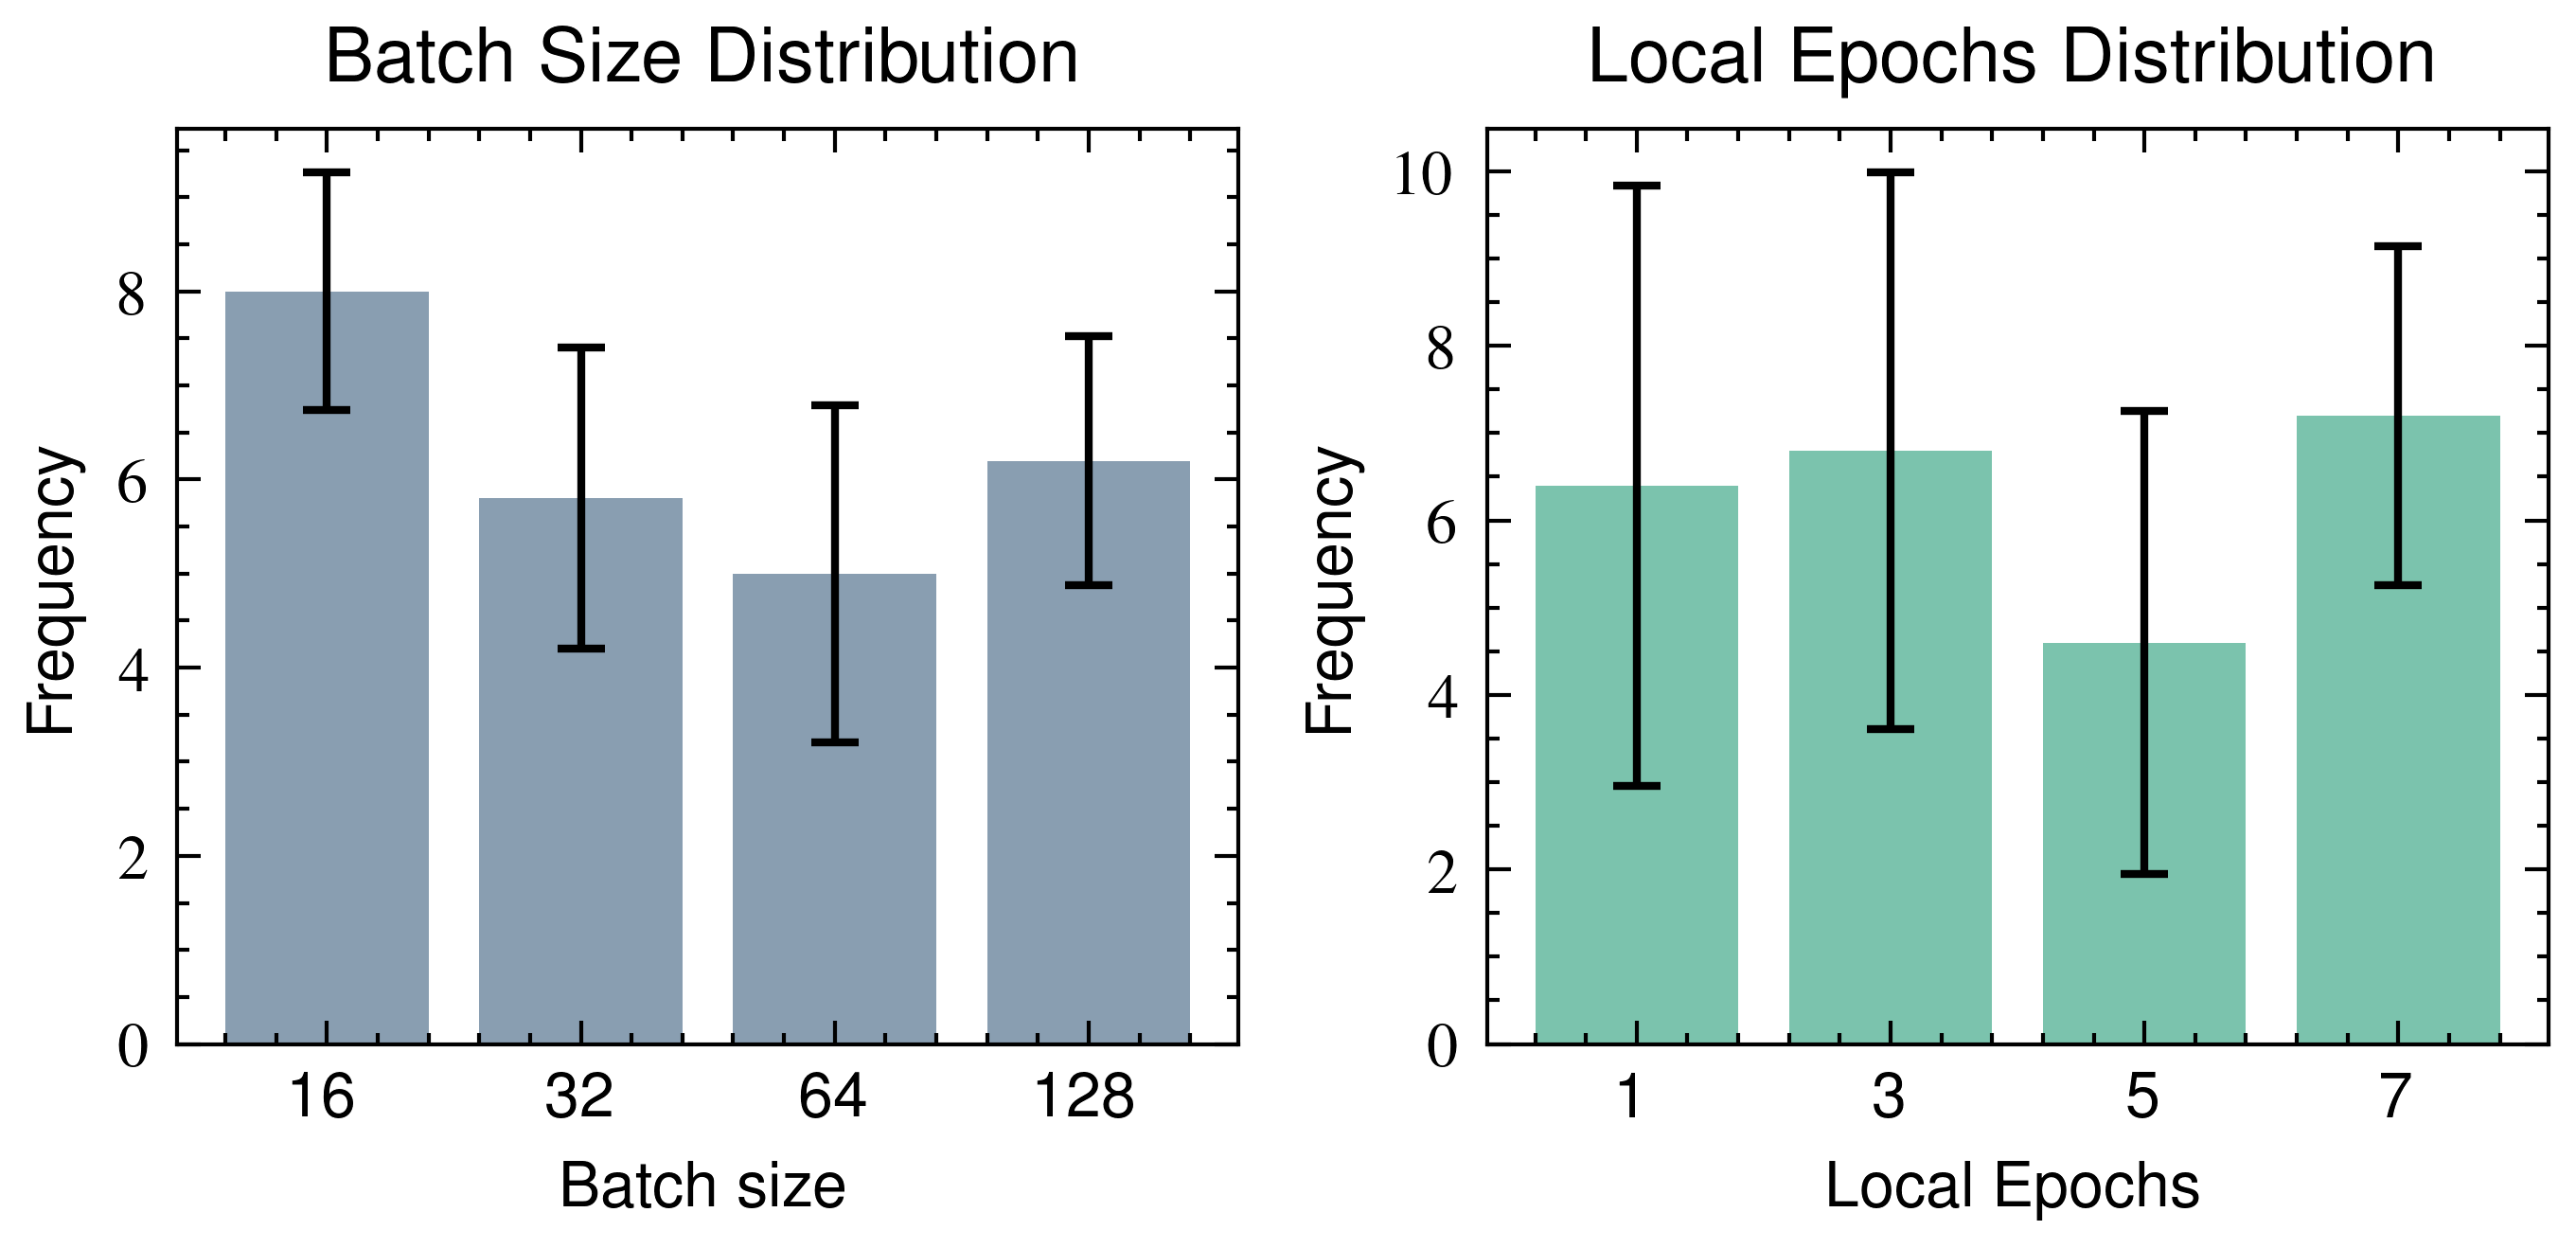

In [26]:
# Calculate frequencies
batch_values_and_counts = [np.unique(batch_sizes, return_counts=True) for batch_sizes in batch_sizess]
epoch_values_and_counts = [np.unique(local_epochs, return_counts=True) for local_epochs in local_epochss]

batch_values = [str(val) for val in batch_values_and_counts[0][0]]
batch_means = np.mean([counts for _, counts in batch_values_and_counts], axis=0)
batch_stddev = np.std([counts for _, counts in batch_values_and_counts], axis=0)

epoch_values = [str(val) for val in epoch_values_and_counts[0][0]]
epoch_means = np.mean([counts for _, counts in epoch_values_and_counts], axis=0)
epoch_stddev = np.std([counts for _, counts in epoch_values_and_counts], axis=0)

# Create 2 bar charts from the batch size and local epochs distributions
fig, ax = plt.subplots(1, 2, figsize=(505/72/1.5, 505/72/3))

# Batch sizes
ax[0].bar(batch_values, batch_means, color='#577590', alpha=0.7, yerr=batch_stddev, capsize=3)
ax[0].set_title("Batch Size Distribution")
ax[0].set_xlabel("Batch size")
ax[0].set_ylabel("Frequency")

# Local epochs
ax[1].bar(epoch_values, epoch_means, color='#43AA8B', alpha=0.7, yerr=epoch_stddev, capsize=3)
ax[1].set_title("Local Epochs Distribution")
ax[1].set_xlabel("Local Epochs")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig('for-report/client_distribution.pdf')
plt.show()

### Visualize data volume and label distribution

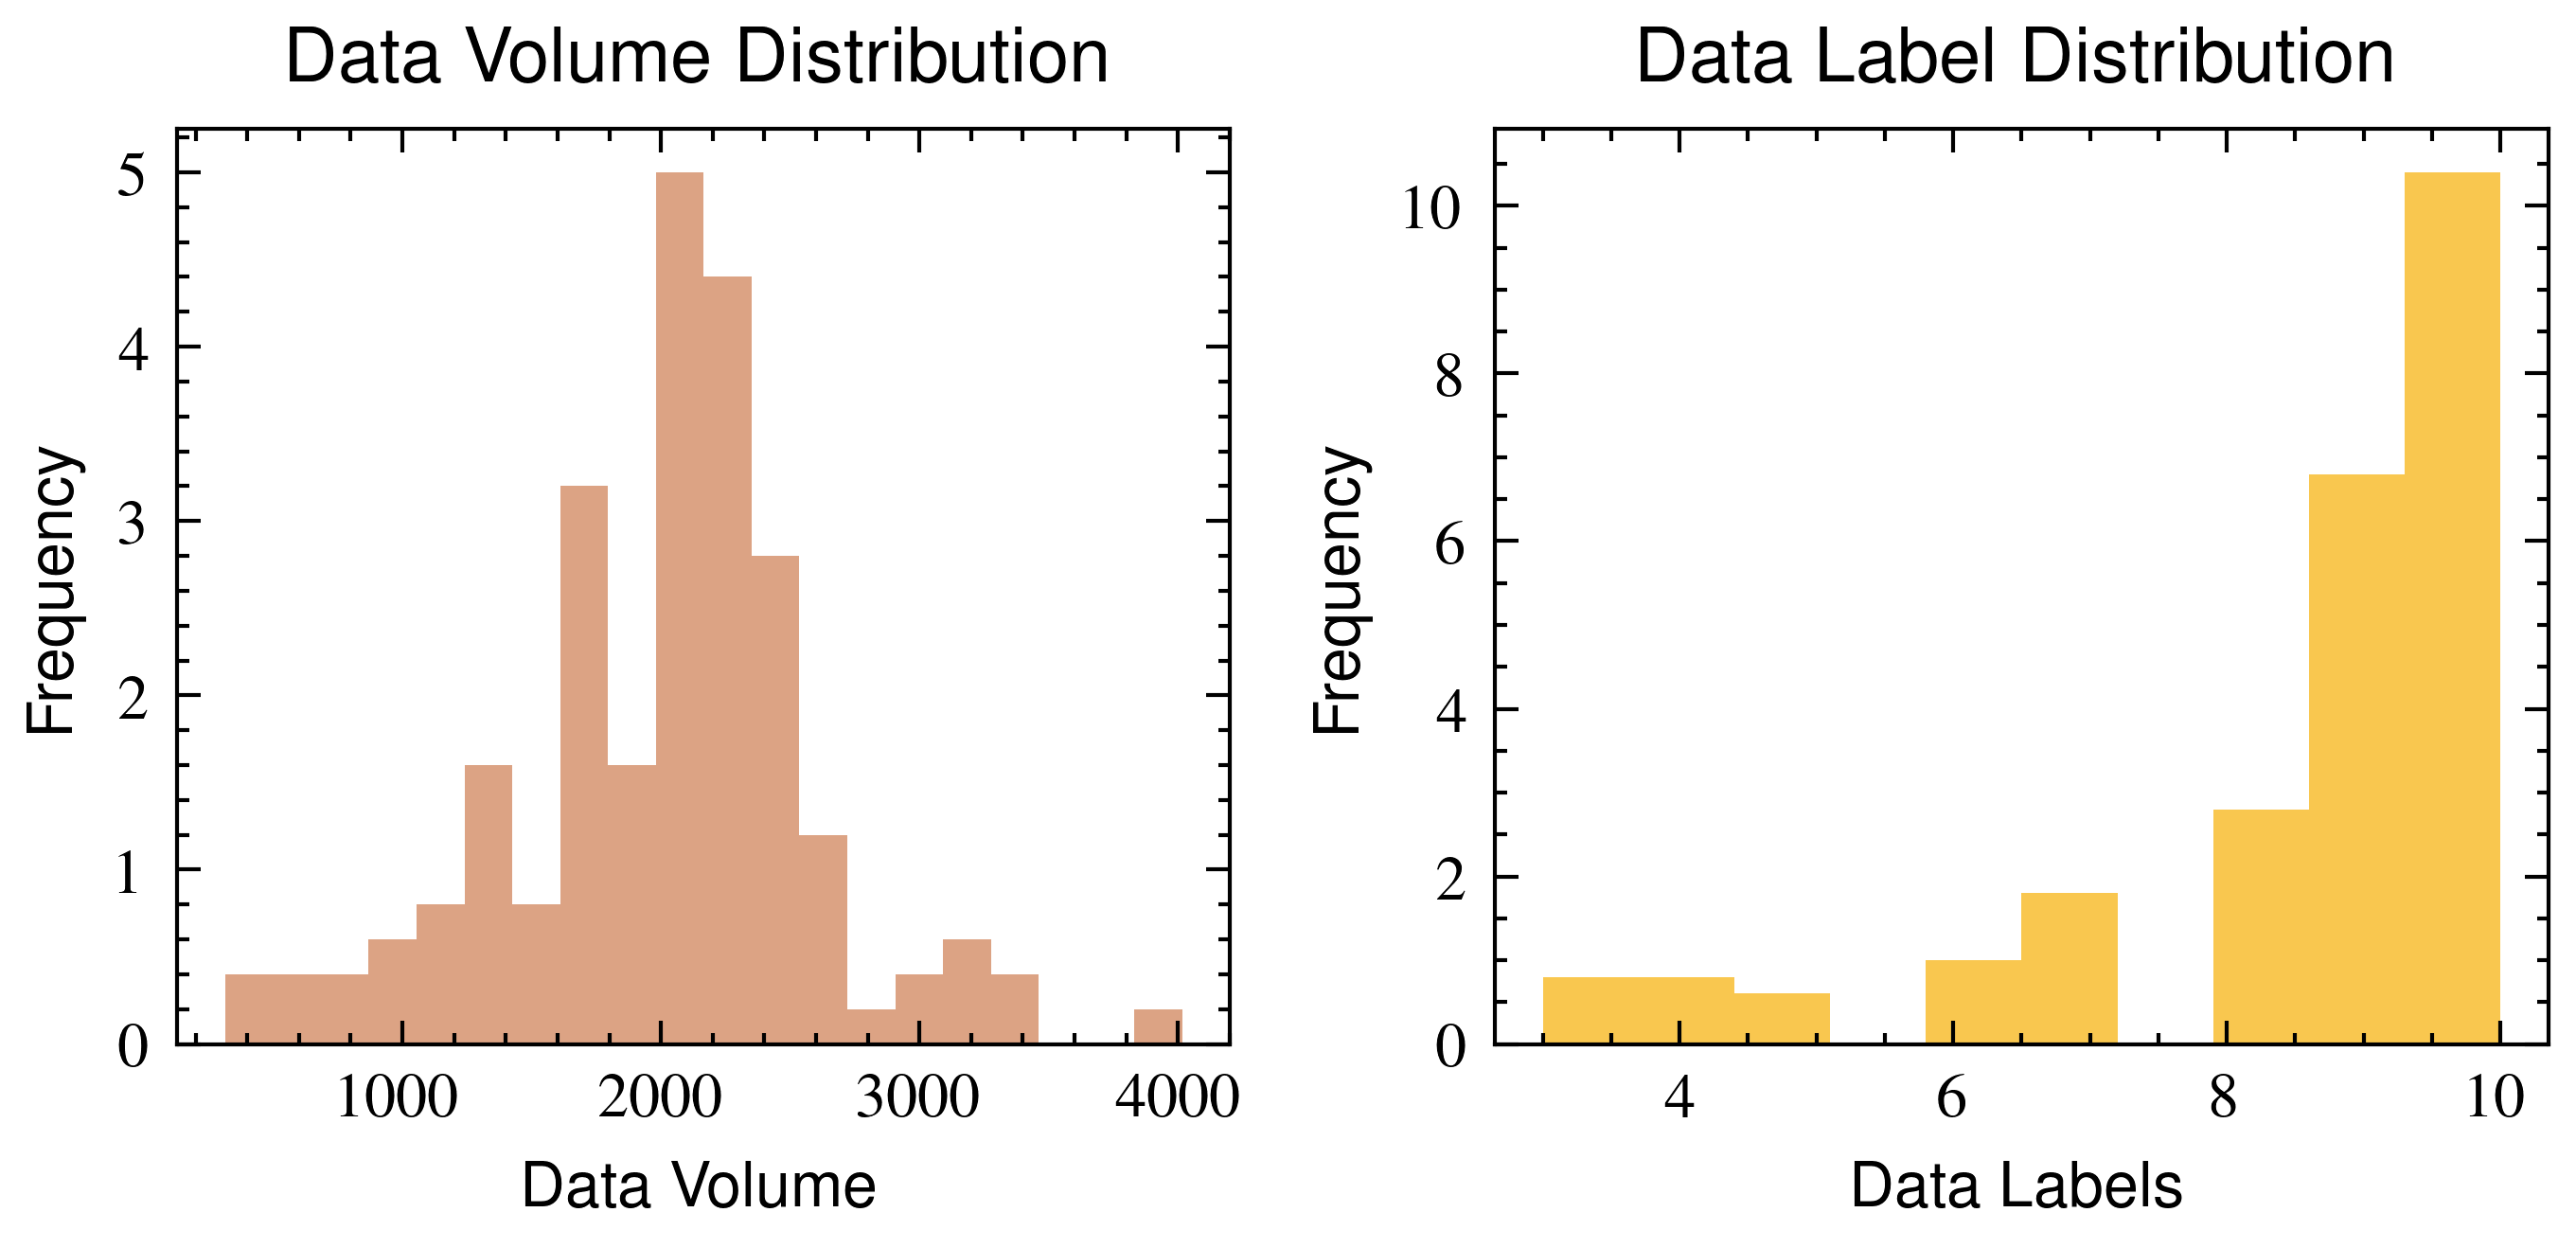

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(505/72/1.5, 505/72/3))
combined_data_volumes = np.concatenate(data_volumess)
ax[0].hist(combined_data_volumes, bins=20, alpha=0.5, color="#bb490b", weights=np.ones_like(combined_data_volumes) / experiment_repetitions)
ax[0].set_title("Data Volume Distribution")
ax[0].set_xlabel("Data Volume")
ax[0].set_ylabel("Frequency")

combined_data_labels = np.concatenate(data_labelss)
ax[1].hist(combined_data_labels, bins=10, color="#F9C74F", weights=np.ones_like(combined_data_labels) / experiment_repetitions)
ax[1].set_title("Data Label Distribution")
ax[1].set_xlabel("Data Labels")
ax[1].set_ylabel("Frequency")

plt.tight_layout()

plt.savefig(f'for-report/data_distribution.pdf')
plt.show()

# Visualize results

In [50]:
from collections import defaultdict, OrderedDict
from visualization.data import RunData

# Define runs to visualize
all_sims = [f"run_{i}" for i in range(650, 680)] # ACTUAL DATA IN REPORT RUNs
# all_sims = [f"run_{i}" for i in range(680, 710)] # COULD BE ACTUAL DATA IN REPORT RUNs (but worse)
all_sims = RunData.build_many(all_sims, base_path="from-hertz/logs")

all_deps = [f"run_{i}" for i in range(2000, 2005)]
all_deps = RunData.build_many(all_deps, base_path="logs")

all_runs = all_sims + all_deps

# Group runs by code to average
runs_by_code = defaultdict(list)
for run in all_runs:
    runs_by_code[run.run_config.code].append(run)
    
# runs_by_code = OrderedDict(sorted(runs_by_code.items()))
runs_by_code = dict(runs_by_code)
# runs_by_code = {key: runs[:1] for key, runs in runs_by_code.items()}

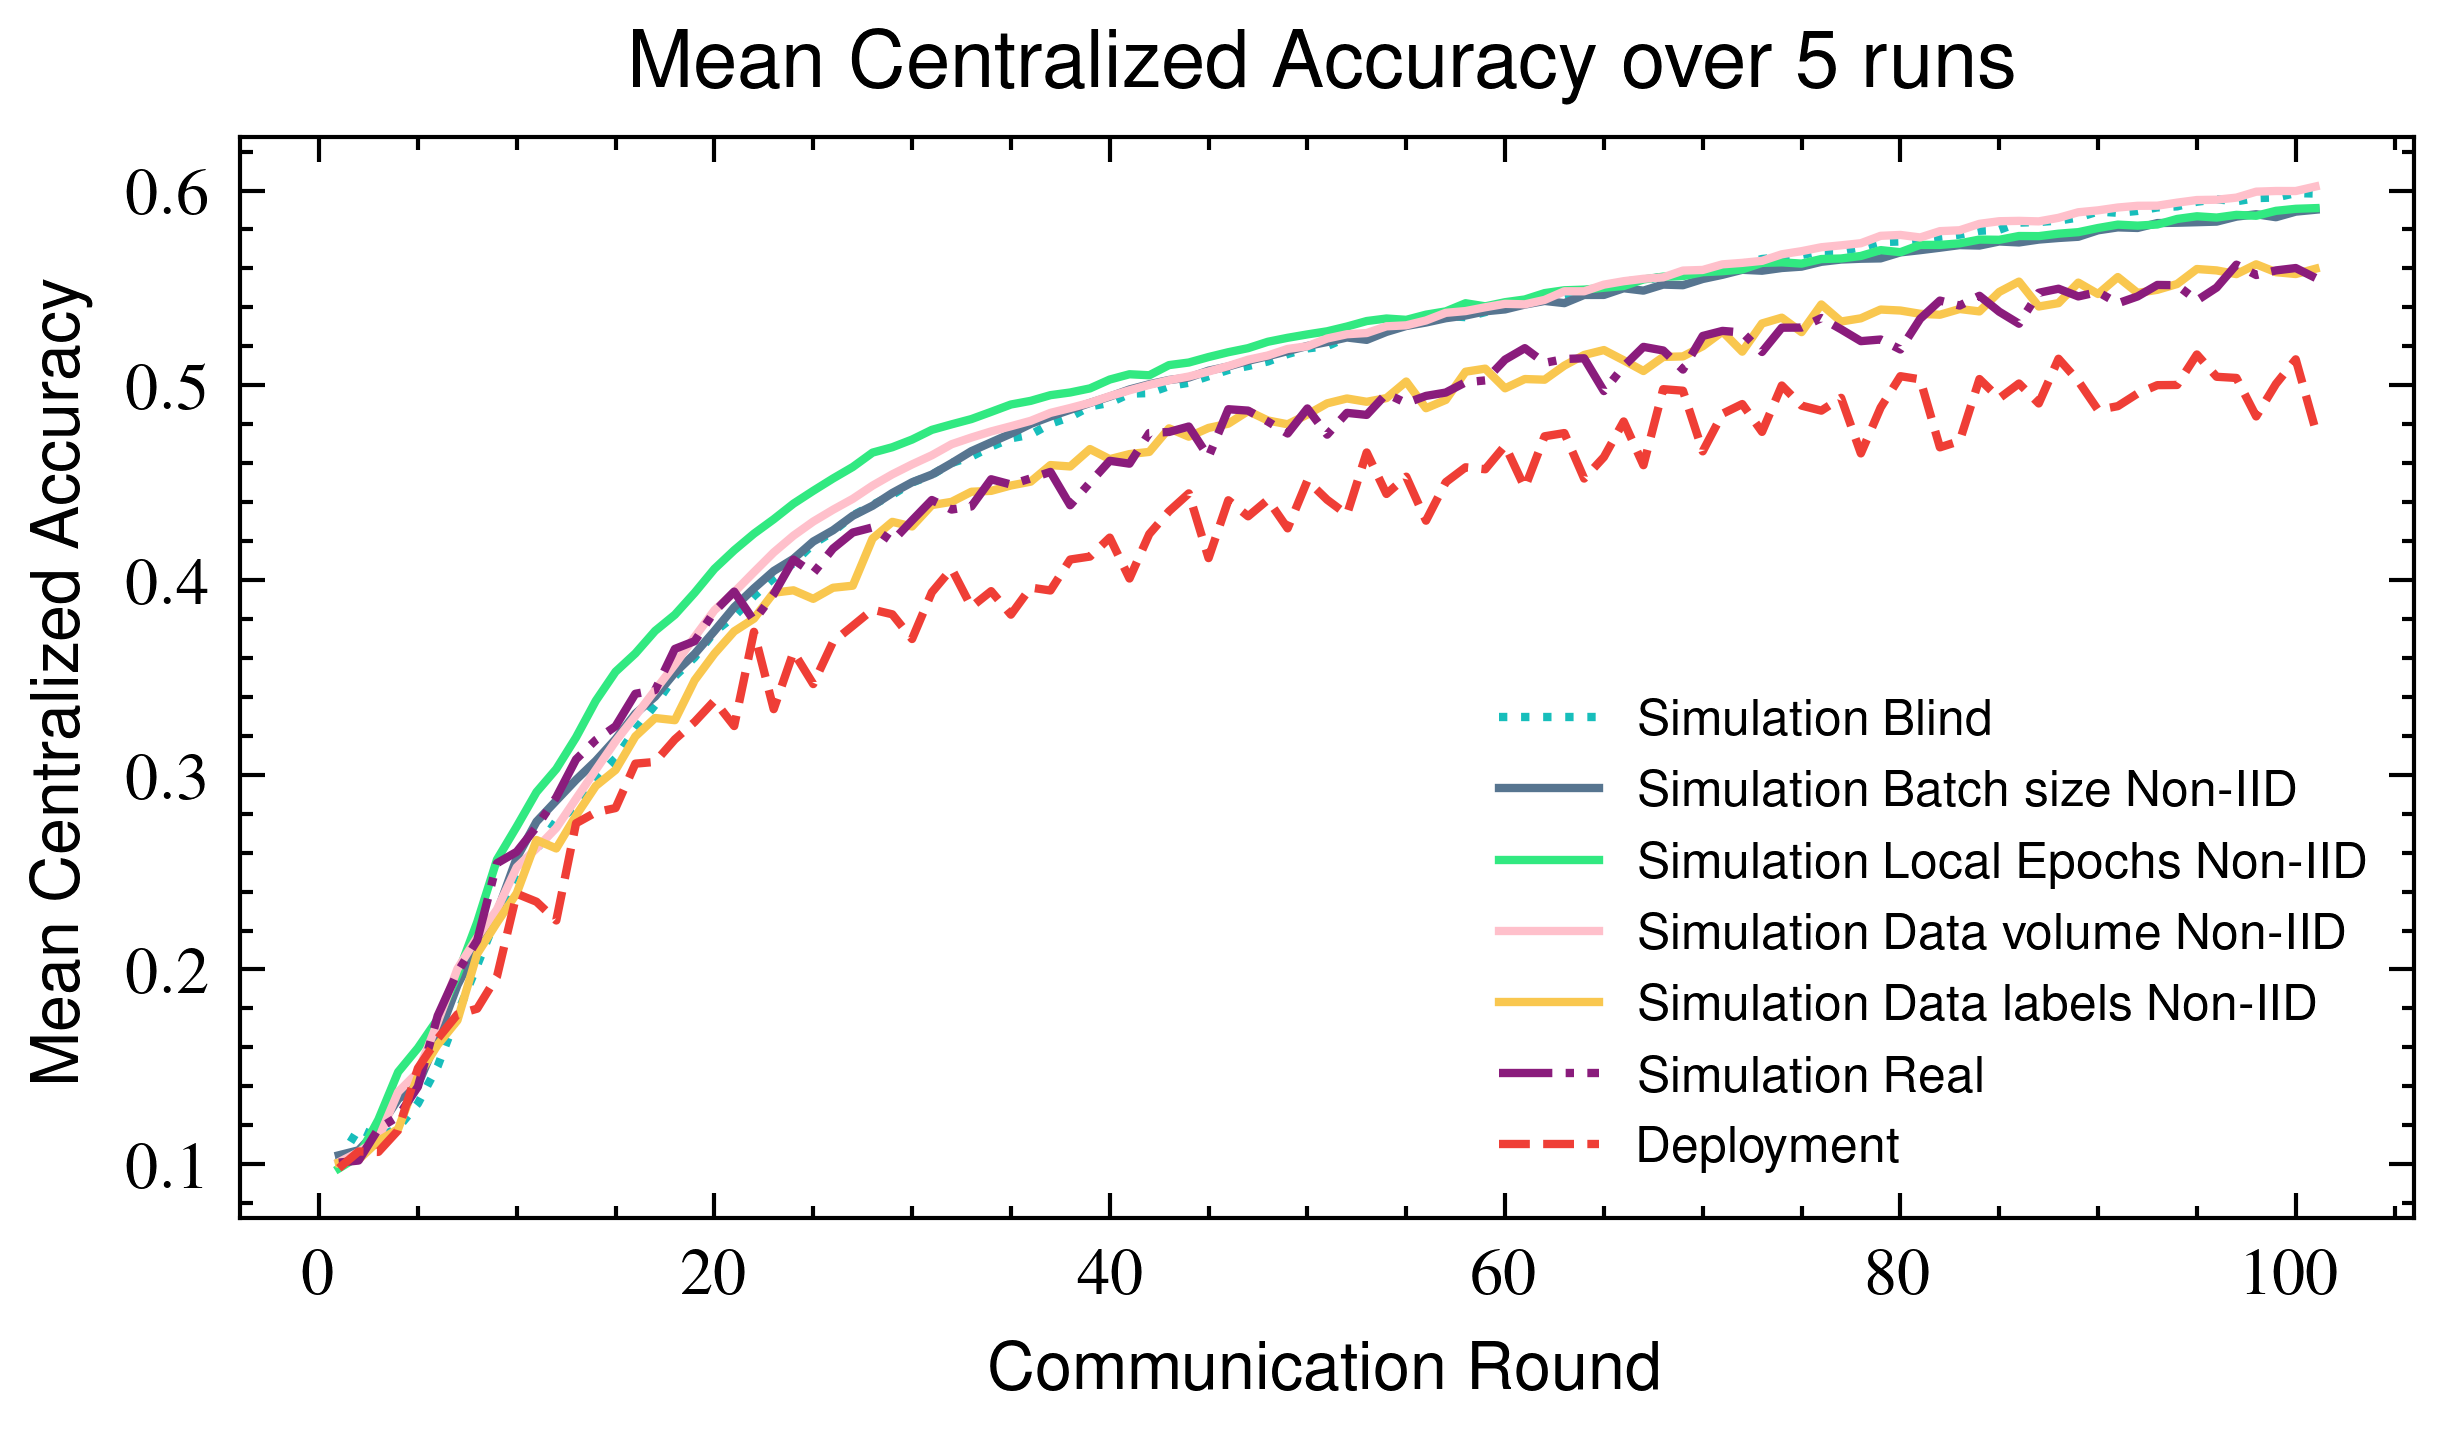

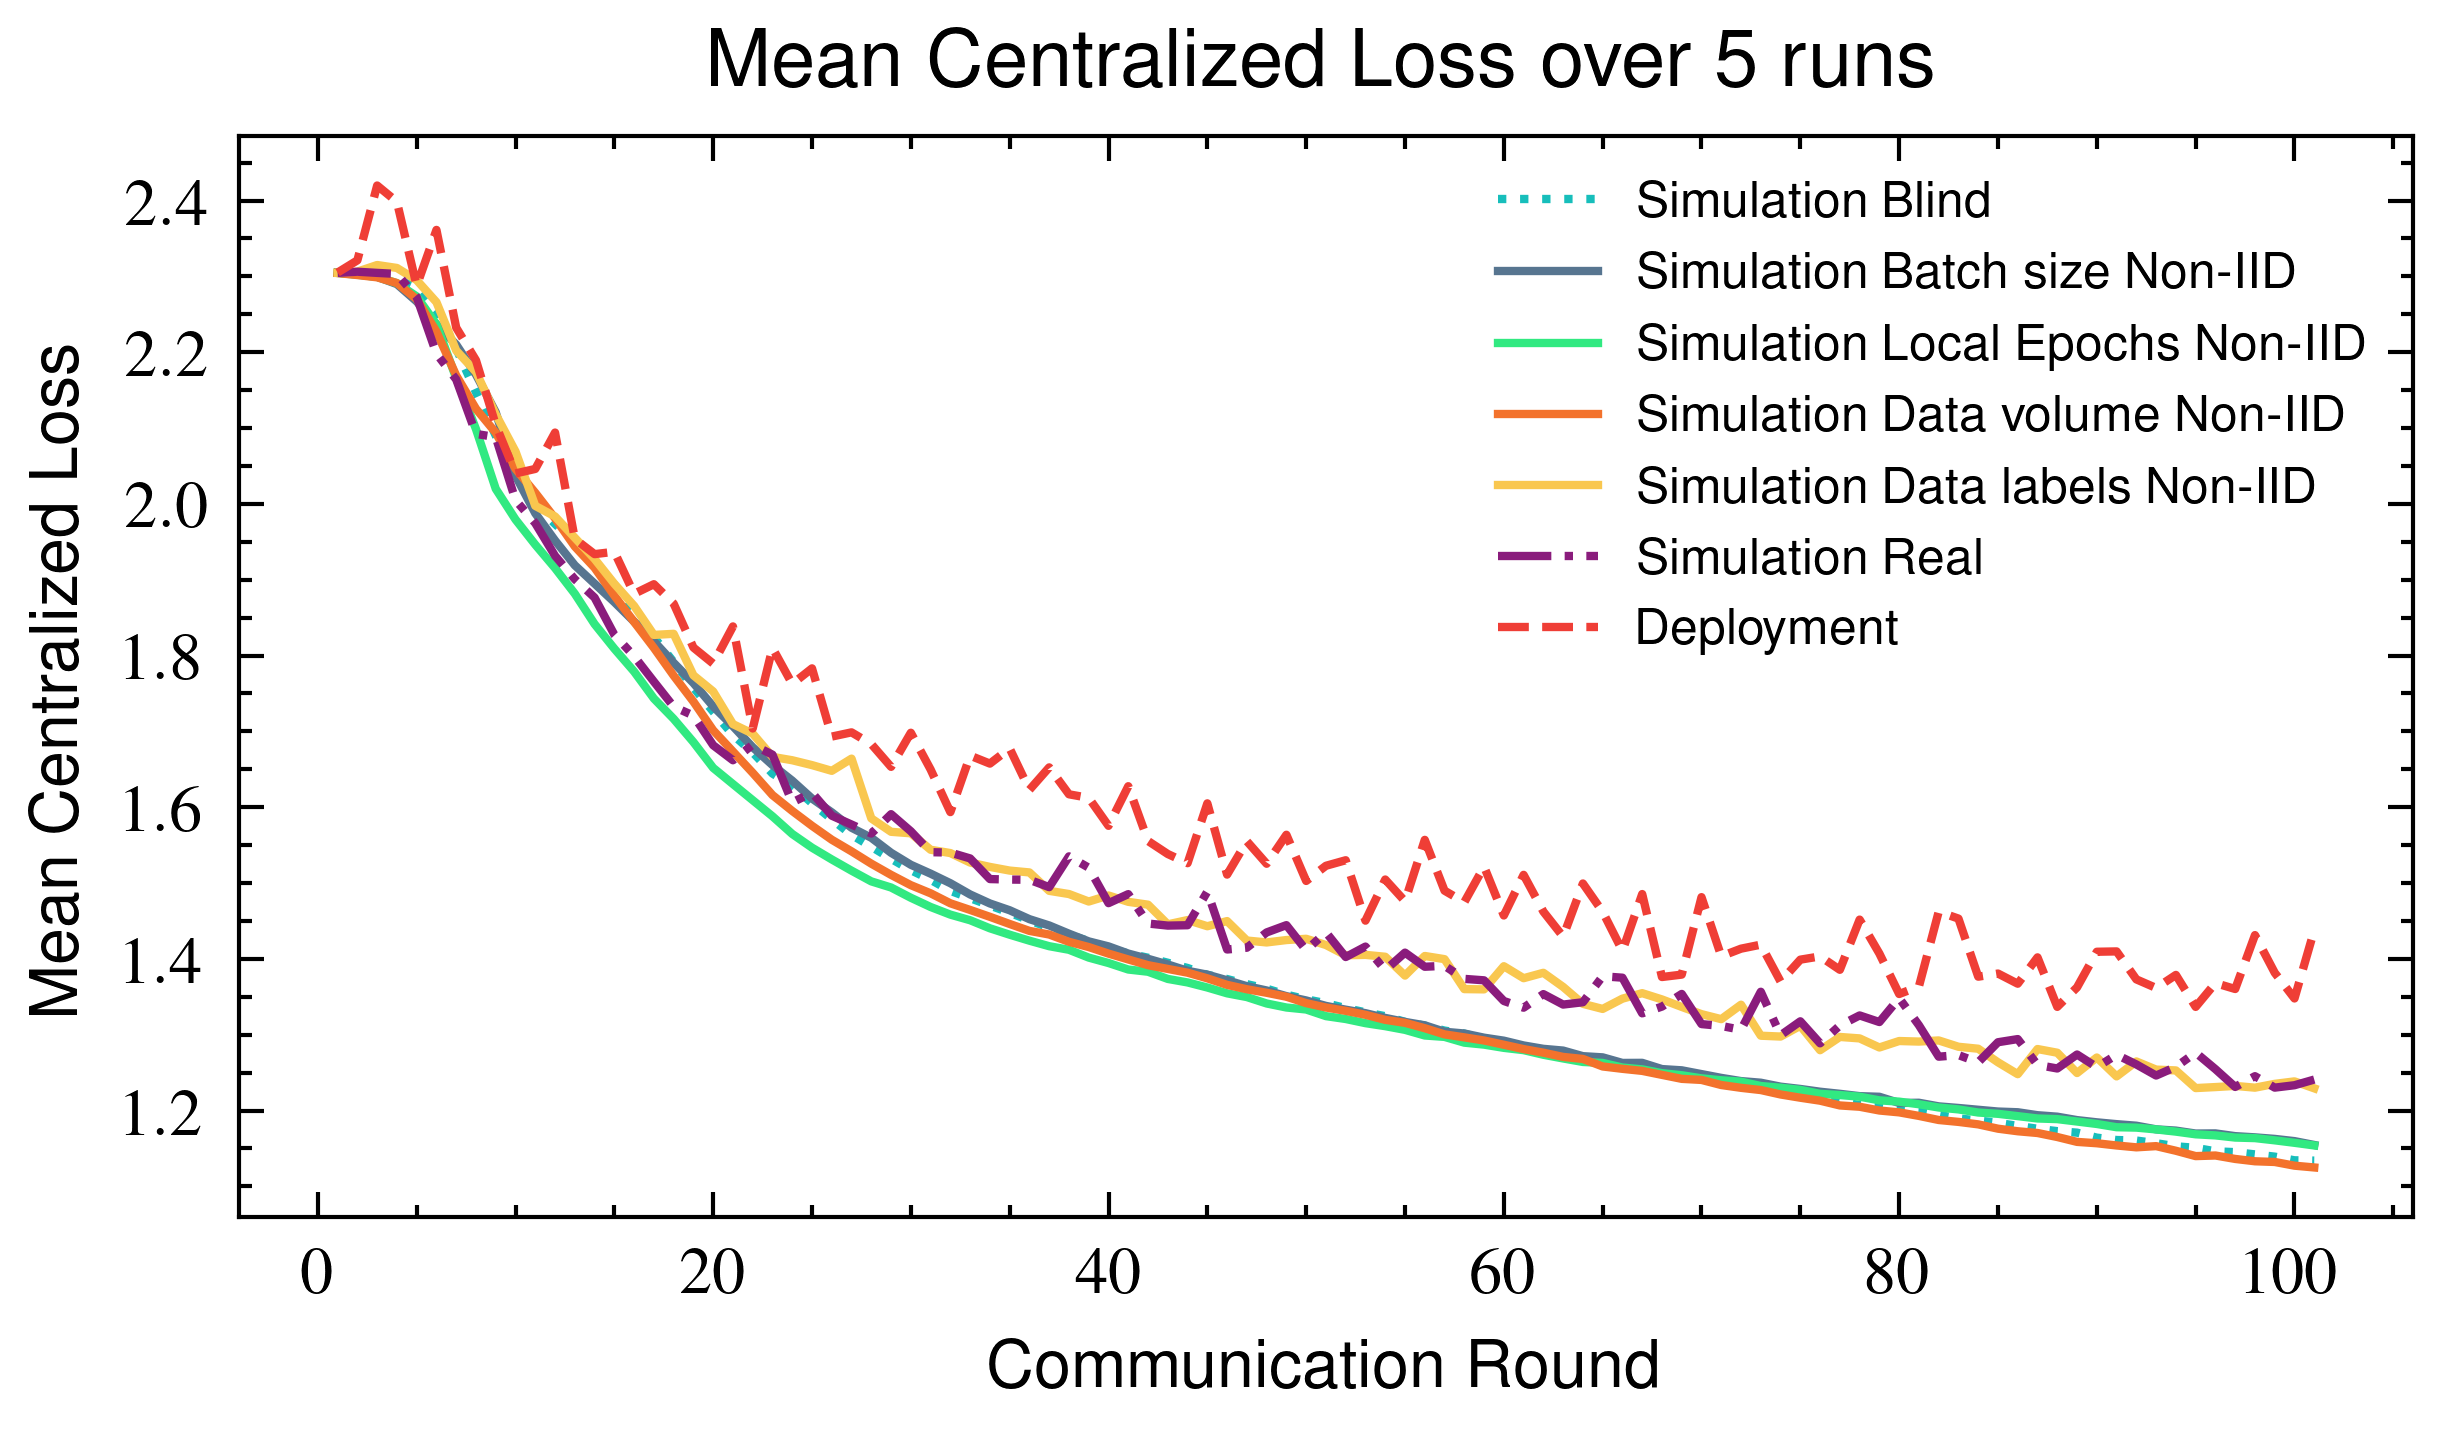

In [49]:
# Plot the accuracy of the runs

def adjust_lightness(color, amount=0.5):
    # Utility function to plot error boundaries of same lighter color
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

for metric in ["accuracy", "loss"]:
    plt.figure(figsize=(505/72/1.5, 505/72/3))
    
    for code, runs in runs_by_code.items():
        run_accuracy = [np.array(run.get_metric(metric).y) for run in runs]
        mean = np.mean(run_accuracy, axis=0)
        std_dev = np.std(run_accuracy, axis=0)
    
        upper_bound = mean + std_dev
        lower_bound = mean - std_dev
        
        style = runs[0].get_metric(metric).style
    
        xs = np.arange(1, len(mean) + 1)
        label = runs[0].run_config.get_label()
        linestyle = "solid"
        if "Real" in label:
            linestyle = "dashdot" 
        elif "Blind" in label:
            linestyle = "dotted"
        elif "Dep" in label:
            linestyle = "dashed"
            
        plt.plot(xs, mean, label=label, color=style.color, linestyle=linestyle)
        # plt.fill_between(xs, lower_bound, upper_bound, color=adjust_lightness(style.color), alpha=0.1)
        
    plt.xlabel('Communication Round')
    plt.ylabel(f'Mean Centralized {metric.capitalize()}')
    plt.title(f'Mean Centralized {metric.capitalize()} over 5 runs')
    plt.legend(fontsize="6")
    plt.savefig(f"for-report/{metric}.pdf")
    plt.show()

# Visualize the correlation between runs

In [40]:
import itertools
from visualization.utils import (
    calculate_mse,
)


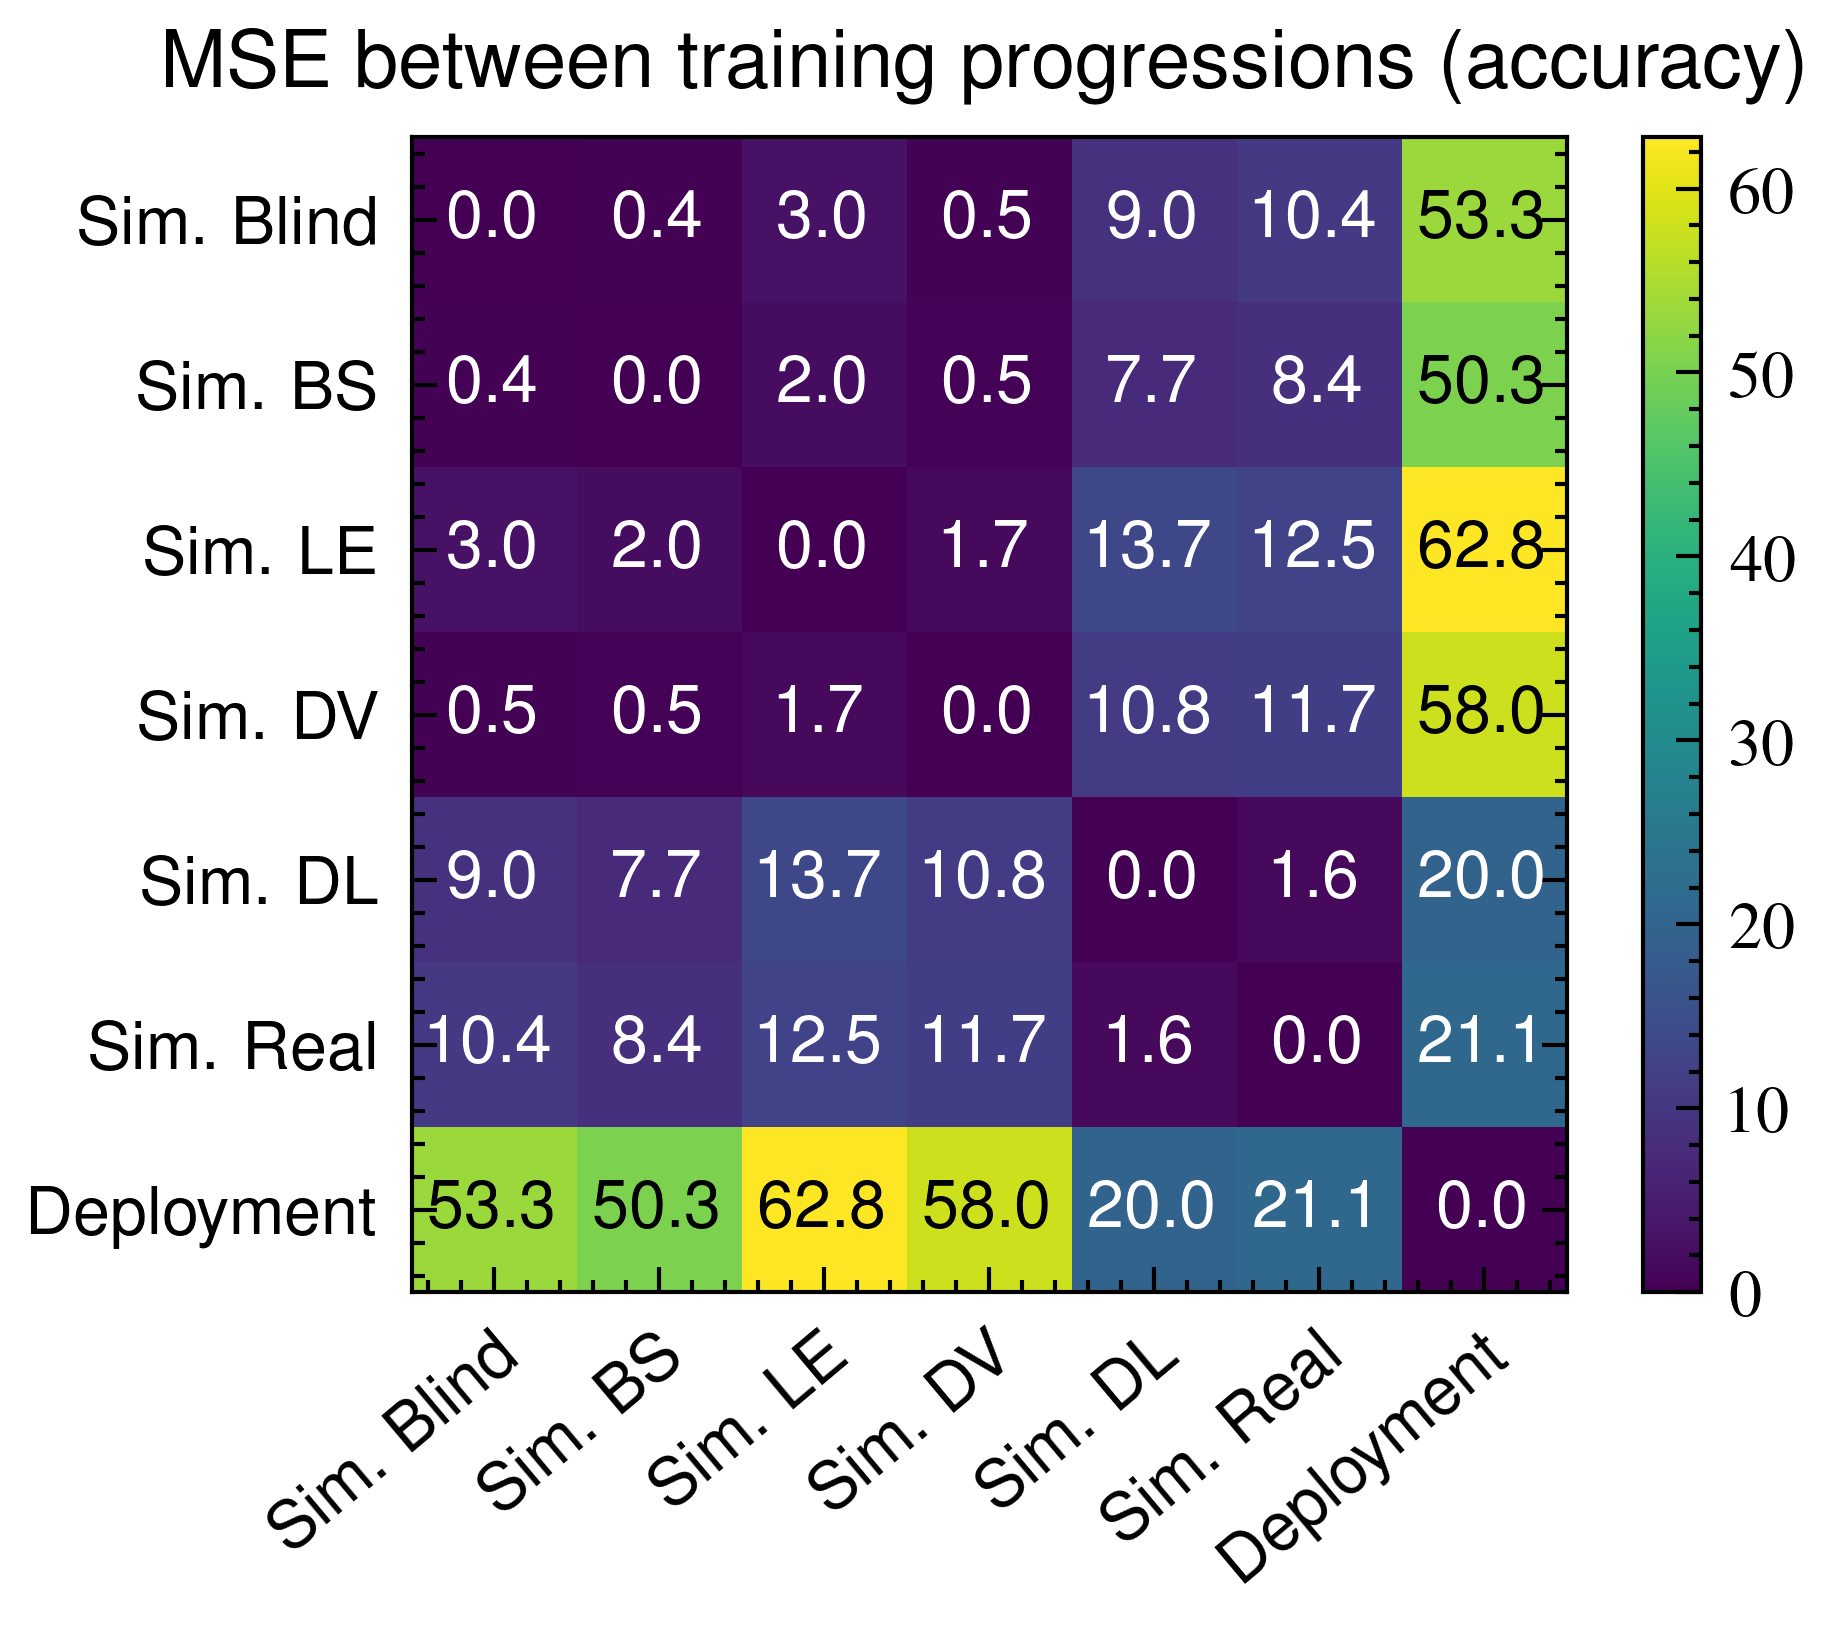

In [43]:
accuracies = [np.mean([np.array(run.get_metric("accuracy").y) for run in runs], axis=0) for code, runs in runs_by_code.items()]
num_arrays = len(runs_by_code)
matrix = np.zeros((num_arrays, num_arrays))

for i, j in itertools.combinations(range(num_arrays), 2):
    mse = calculate_mse(accuracies[i] * 100, accuracies[j] * 100)
    matrix[i, j] = mse
    matrix[j, i] = mse

fig, ax = plt.subplots()
cax = ax.matshow(matrix, cmap="viridis", interpolation="none")
fig.colorbar(cax)

avg = np.average(matrix)

for (i, j), z in np.ndenumerate(matrix):
    ax.text(
        j,
        i,
        "{:d}".format(int(round(z))) if z > 100 else "{:0.1f}".format(z),
        ha="center",
        va="center",
        color="white" if z < avg / 0.5 else "black",
    )

# Set ticks and labels
ax.set_xticks(range(num_arrays))
ax.set_yticks(range(num_arrays))
labels = [run[0].run_config.get_label(short=True) for run in runs_by_code.values()]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=40, ha="right", rotation_mode="anchor") 

plt.title("MSE between training progressions (accuracy)")
plt.savefig("for-report/mse_correlogram.pdf", bbox_inches='tight')
plt.show()

# Output CSV files for results

In [51]:
with open("for-report/table_results.csv", "w") as file:
    file.write("Configuration,Accuracy,Loss,MSE vs Dep.\n")
    deployments = runs_by_code[next(iter([code for code in runs_by_code.keys() if "dep" in code]))]
    deployments = [np.array(run.get_metric("accuracy").y) for run in deployments]
    mean_deps = np.mean(deployments, axis=0) * 100
    for code, runs in runs_by_code.items():
        run_accuracy = [np.array(run.get_metric("accuracy").y) for run in runs]
        max_accs = [np.max(run) for run in run_accuracy]
        mean_max_acc = np.mean(max_accs) * 100
        std_acc = np.std(max_accs) * 100
        mean_accs = np.mean(run_accuracy, axis=0) * 100
        
        run_loss = [np.array(run.get_metric("loss").y) for run in runs]
        min_losses = [np.min(run) for run in run_loss]
        mean_loss = np.mean(min_losses)
        std_loss = np.std(min_losses)
        
        
        mse = calculate_mse(mean_accs, mean_deps)
        
        data = [
            runs[0].run_config.get_label(short=True),
            f"{np.max(mean_max_acc):.2f}% ± {std_acc:.2f}%",
            # std_acc,
            f"{np.max(mean_loss):.2f} ± {std_loss:.2f}",
            f"{mse:.2f}",
            # np.max(mean_loss),
            # std_loss
        ]
        
        file.write(",".join(data) + "\n")

# Algorithm for replicating clients

In [ ]:
"""
SEED = 42
DATASET = "cifar10"
NUM_CLIENTS = 50

def replicate_clients(
    datapoints_per_client: List[int],
    labels_per_client: List[int],
):
    prng = np.random.default_rng(SEED)

    label_indices = {
        k: np.where(DATASET.targets == k)[0].tolist() for k in range(DATASET.classes)
    }
    for indices in label_indices.values():
        prng.shuffle(indices)

    idx_clients: List[List[int]] = [[] for _ in range(NUM_CLIENTS)]

    for client_id, (num_samples, num_labels) in enumerate(
        zip(datapoints_per_client, labels_per_client)
    ):
        selected_labels = prng.choice(range(DATASET.classes), num_labels, replace=False)
        client_indices = []

        for label in selected_labels:
            count_needed = (num_samples // num_labels) + (
                1 if num_samples % num_labels > 0 else 0
            )
            count_assigned = 0

            while label_indices[label] and count_assigned < count_needed:
                client_indices.append(label_indices[label].pop())
                count_assigned += 1

        prng.shuffle(client_indices)
        idx_clients[client_id] = client_indices[:num_samples]

    remaining_indices = [idx for indices in label_indices.values() for idx in indices]
    prng.shuffle(remaining_indices)

    for client_id in range(NUM_CLIENTS):
        if len(idx_clients[client_id]) < datapoints_per_client[client_id]:
            required = datapoints_per_client[client_id] - len(idx_clients[client_id])
            idx_clients[client_id].extend(remaining_indices[:required])
            remaining_indices = remaining_indices[required:]

    return idx_clients
"""